# DBSCAN

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Libraries import

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn import metrics
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from scipy.spatial import distance
import array

import time

## DBSCAN hyperparameter tuner
Sander, J., Ester, M., Kriegel, H. P., & Xu, X. (1998). Density-based clustering in spatial databases: The algorithm gdbscan and its applications. Data mining and knowledge discovery, 2(2), 169-194.

In [3]:
def dbscan_tuner(data,dim):
    a = data.loc[:, (data.columns != 'y')&(data.columns != 'Outlier')
                 &(data.columns != 'Class')&(data.columns != 'Unusual')
                 &(data.columns != 'class')]
    a = a.to_numpy()
    b = distance.cdist(a,a)
    
    dist = []
    for i in b:
        l = sorted(i)[dim]
        dist.append(l)
        
    c = data.loc[:, (data.columns != 'y')&(data.columns != 'Outlier')
                 &(data.columns != 'Class')&(data.columns != 'Unusual')
                 &(data.columns != 'class')]
    c['dist'] = dist
    c = c.sort_values(by='dist')
    d = array.array('i',(i for i in range(1,len(data)+1)))
    c['i'] = d
    
    plt.plot(c['i'],c['dist'])
    plt.xlabel("Observation index")
    plt.ylabel("k-distance")
    
    return c

## Prediction translation

In [4]:
def def_outlier(df):
    if (df['y_pred'] in [-1]):
        val = 1
    else:
        val = 0
    return val

## Arrhythmia

**Dataset source**: http://odds.cs.stonybrook.edu/arrhythmia-dataset/ (data is transformed from .mat to .csv format)

Shebuti Rayana (2016). ODDS Library [http://odds.cs.stonybrook.edu]. Stony Brook, NY: Stony Brook University, Department of Computer Science.

**Additional sources**:

Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou. “Isolation forest.” 2008 Eighth IEEE International Conference on Data Mining. IEEE, 2008.

K. M. Ting, J. T. S. Chuan, and F. T. Liu. “Mass: A New Ranking Measure for Anomaly Detection.“, IEEE Transactions on Knowledge and Data Engineering, 2009.

F. Keller, E. Muller, K. Bohm.“HiCS: High-contrast subspaces for density-based outlier ranking.” ICDE, 2012.

In [5]:
data = pd.read_csv('./arrhythmia.csv', sep = ',')

In [6]:
# dropping columns that consist only of 0's
data = data.drop(columns = ['Col15', 'Col63', 'Col65', 'Col79', 'Col127', 'Col128','Col135', 'Col137', 'Col139','Col141',
'Col147', 'Col152', 'Col153','Col160','Col200', 'Col260', 'Col270'])

In [7]:
data.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,...,Col265,Col266,Col267,Col268,Col269,Col271,Col272,Col273,Col274,y
0,75.0,0.0,190.0,80.0,91.0,193.0,371.0,174.0,121.0,-16.0,...,-0.3,0.0,9.0,-0.9,0.0,0.9,2.9,23.3,49.4,1
1,56.0,1.0,165.0,64.0,81.0,174.0,401.0,149.0,39.0,25.0,...,-0.5,0.0,8.5,0.0,0.0,0.2,2.1,20.4,38.8,0
2,54.0,0.0,172.0,95.0,138.0,163.0,386.0,185.0,102.0,96.0,...,0.9,0.0,9.5,-2.4,0.0,0.3,3.4,12.3,49.0,0
3,55.0,0.0,175.0,94.0,100.0,202.0,380.0,179.0,143.0,28.0,...,0.1,0.0,12.2,-2.2,0.0,0.4,2.6,34.6,61.6,0
4,75.0,0.0,190.0,80.0,88.0,181.0,360.0,177.0,103.0,-16.0,...,-0.4,0.0,13.1,-3.6,0.0,-0.1,3.9,25.4,62.8,1


In [8]:
data.shape

(452, 258)

In [9]:
pd.pivot_table(data,
             values = 'Col1',
               index = 'y', 
              aggfunc = 'count')

,Col1
y,
0,386
1,66


### DBSCAN

In [10]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
train_data = min_max_scaler.fit_transform(data.copy())
train_data = pd.DataFrame(train_data)
train_data.columns = data.columns

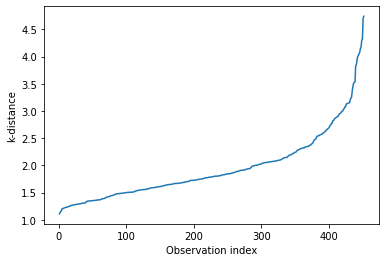

In [11]:
dist = dbscan_tuner(train_data,25)

In [12]:
start = time.process_time()
dbscan = DBSCAN(eps = 2.5, min_samples = 40)
clusters = dbscan.fit_predict(train_data.loc[:, train_data.columns != 'y'])

end = time.process_time()
arrhythmia_dbscan_train_test_time = end - start
print(end - start)

0.8125


In [13]:
train_data['y_pred'] = clusters
train_data['prediction'] = train_data.apply(def_outlier, axis = 1)

In [14]:
original_columns = data.columns.to_list()
original_columns.remove('y')

data_w_score = pd.DataFrame(columns = train_data.columns.to_list())
data_w_score['score'] = pd.NaT
for i in set(clusters):
    if i == -1:
        continue
    score_data = train_data[train_data['y_pred'] == i].copy()
    center = score_data[original_columns].mean().to_list()
    score_data['score'] = score_data.apply(lambda x : distance.euclidean(x[original_columns].to_list(), center),1)
    data_w_score = data_w_score.append(score_data.copy(), ignore_index = True)

anomalies_data = train_data[train_data['y_pred'] == -1].copy()
anomalies_data['score'] = ''
cluster_centers = pd.pivot_table(train_data,
              index = 'y_pred',
              aggfunc = 'mean')

for i in range(len(anomalies_data)):
    anomalies_data['score'].iloc[i] = np.min(cluster_centers[cluster_centers.index != -1].apply(lambda x : 
                                                                                                distance.euclidean(x[original_columns].to_list(), anomalies_data[original_columns].iloc[i]),1))

data_for_auprc = pd.concat([data_w_score, anomalies_data])
data_for_auprc['y'] = data_for_auprc['y'].astype(int)

In [15]:
confusion_matrix(train_data['y'], train_data['prediction'])

array([[371,  15],
       [ 45,  21]], dtype=int64)

In [16]:
fpr, tpr, _ = metrics.roc_curve(data_for_auprc['y'], data_for_auprc['score'])
arrhythmia_dbscan_auc = metrics.auc(fpr, tpr)
metrics.auc(fpr, tpr)

0.7975349348406344

In [17]:
arrhythmia_dbscan_report = classification_report(train_data['y'], train_data['prediction'], target_names = ['0','1'], output_dict=True)
print(classification_report(train_data['y'], train_data['prediction'], target_names = ['0','1']))

              precision    recall  f1-score   support

           0       0.89      0.96      0.93       386
           1       0.58      0.32      0.41        66

    accuracy                           0.87       452
   macro avg       0.74      0.64      0.67       452
weighted avg       0.85      0.87      0.85       452



In [18]:
precision, recall, thresholds = precision_recall_curve(data_for_auprc['y'], data_for_auprc['score'])
arrhythmia_dbscan_auc_precision_recall = metrics.auc(recall, precision)
print(arrhythmia_dbscan_auc_precision_recall)

0.45604941094873613


## Cardiotocography

**Dataset source**: http://odds.cs.stonybrook.edu/cardiotocogrpahy-dataset/ (data is transformed from .mat to .csv format)

Shebuti Rayana (2016). ODDS Library [http://odds.cs.stonybrook.edu]. Stony Brook, NY: Stony Brook University, Department of Computer Science.

**Additional sources**:

C. C. Aggarwal and S. Sathe, “Theoretical foundations and algorithms for outlier ensembles.” ACM SIGKDD Explorations Newsletter, vol. 17, no. 1, pp. 24–47, 2015.

Saket Sathe and Charu C. Aggarwal. LODES: Local Density meets Spectral Outlier Detection. SIAM Conference on Data Mining, 2016.

In [19]:
data = pd.read_csv('./Cardiotocography.csv')

In [20]:
data.shape

(1831, 22)

In [21]:
data['y'] = data['y'].astype(int)

In [22]:
pd.pivot_table(data,
             values = 'Col1',
               index = 'y', 
              aggfunc = 'count')

,Col1
y,
0,1655
1,176


In [23]:
data.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,...,Col13,Col14,Col15,Col16,Col17,Col18,Col19,Col20,Col21,y
0,0.004912,0.693191,-0.203640,0.595322,0.353190,-0.061401,-0.278295,-1.650444,0.759072,-0.420487,...,-0.798376,1.854728,0.622631,0.963083,0.301464,0.193113,0.231498,-0.289786,-0.493294,0
1,0.110729,-0.079903,-0.203640,1.268942,0.396246,-0.061401,-0.278295,-1.710270,0.759072,-0.420487,...,-0.798376,1.854728,0.278625,0.963083,0.301464,0.129265,0.093563,-0.256385,-0.493294,0
2,0.216546,-0.272445,-0.203640,1.050988,0.148753,-0.061401,-0.278295,-1.710270,1.106509,-0.420487,...,-1.332931,0.314688,2.342663,-0.488279,0.061002,0.065417,0.024596,-0.256385,1.140018,0
3,0.004912,0.727346,-0.203640,1.212171,-0.683598,-0.061401,-0.278295,-1.710270,1.106509,-0.420487,...,-1.332931,0.314688,1.654650,-0.488279,0.061002,0.193113,0.093563,-0.323186,1.140018,0
4,-0.100905,0.363595,1.321366,1.027120,0.141359,-0.061401,-0.278295,-0.992364,-0.051613,-0.420487,...,-0.085638,-0.565334,0.278625,-0.488279,-0.059229,0.065417,0.024596,-0.456787,1.140018,0


### DBSCAN

In [24]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
train_data = min_max_scaler.fit_transform(data.copy())
train_data = pd.DataFrame(train_data)
train_data.columns = data.columns

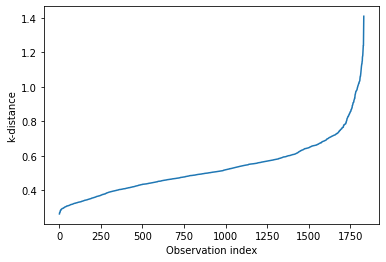

In [25]:
dist = dbscan_tuner(train_data,41)

In [26]:
start = time.process_time()
dbscan = DBSCAN(eps = 0.7, min_samples = 42)
clusters = dbscan.fit_predict(train_data.loc[:, train_data.columns != 'y'])
end = time.process_time()
cardio_dbscan_train_test_time = end - start
print(end - start)

0.453125


In [27]:
train_data['y_pred'] = clusters
train_data['prediction'] = train_data.apply(def_outlier, axis = 1)

In [28]:
original_columns = data.columns.to_list()
original_columns.remove('y')

data_w_score = pd.DataFrame(columns = train_data.columns.to_list())
data_w_score['score'] = pd.NaT
for i in set(clusters):
    if i == -1:
        continue
    score_data = train_data[train_data['y_pred'] == i].copy()
    center = score_data[original_columns].mean().to_list()
    score_data['score'] = score_data.apply(lambda x : distance.euclidean(x[original_columns].to_list(), center),1)
    data_w_score = data_w_score.append(score_data.copy(), ignore_index = True)

anomalies_data = train_data[train_data['y_pred'] == -1].copy()
anomalies_data['score'] = ''
cluster_centers = pd.pivot_table(train_data,
              index = 'y_pred',
              aggfunc = 'mean')

In [29]:
for i in range(len(anomalies_data)):
    anomalies_data['score'].iloc[i] = np.min(cluster_centers[cluster_centers.index != -1].apply(lambda x : 
                                                                                                distance.euclidean(x[original_columns].to_list(), anomalies_data[original_columns].iloc[i]),1))

data_for_auprc = pd.concat([data_w_score, anomalies_data])
data_for_auprc['y'] = data_for_auprc['y'].astype(int)

In [30]:
confusion_matrix(train_data['y'], train_data['prediction'])

array([[1635,   20],
       [ 134,   42]], dtype=int64)

In [31]:
fpr, tpr, _ = metrics.roc_curve(data_for_auprc['y'], data_for_auprc['score'])
cardio_dbscan_auc = metrics.auc(fpr, tpr)
metrics.auc(fpr, tpr)

0.9455781378742104

In [32]:
cardio_dbscan_report = classification_report(train_data['y'], train_data['prediction'], target_names = ['0','1'], output_dict = True)
print(classification_report(train_data['y'], train_data['prediction'], target_names = ['0','1']))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96      1655
           1       0.68      0.24      0.35       176

    accuracy                           0.92      1831
   macro avg       0.80      0.61      0.65      1831
weighted avg       0.90      0.92      0.90      1831



In [33]:
precision, recall, thresholds = precision_recall_curve(data_for_auprc['y'], data_for_auprc['score'])
cardio_dbscan_auc_precision_recall = metrics.auc(recall, precision)
print(cardio_dbscan_auc_precision_recall)

0.6419288401100752


## ForestCover

**Dataset source**: http://odds.cs.stonybrook.edu/forestcovercovertype-dataset/ (data is transformed from .mat to .csv format)

Shebuti Rayana (2016). ODDS Library [http://odds.cs.stonybrook.edu]. Stony Brook, NY: Stony Brook University, Department of Computer Science.

**Additional sources:**

Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou. “Isolation forest.” 2008 Eighth IEEE International Conference on Data Mining. IEEE, 2008.

K. M. Ting, J. T. S. Chuan, and F. T. Liu. “Mass: A New Ranking Measure for Anomaly Detection.“, IEEE Transactions on Knowledge and Data Engineering, 2009.

Kai Ming Ting, Guang-Tong Zhou, Fei Tony Liu & Tan Swee Chuan. (2010). Mass Estimation and Its Applications. Proceedings of The 16th ACM SIGKDD Conference on Knowledge Discovery and Data Mining 2010. pp. 989-998.

Swee Chuan Tan, Kai Ming Ting & Fei Tony Liu. (2011). Fast Anomaly Detection for Streaming Data. Proceedings of the International Joint Conference on Artificial Intelligence 2011. pp.1151-1156.

In [34]:
data = pd.read_csv('./ForestCover.csv')

In [35]:
data.shape

(286048, 11)

In [36]:
pd.pivot_table(data,
             values = 'Col2',
               index = 'y', 
              aggfunc = 'count')

,Col2
y,
0,283301
1,2747


In [37]:
data.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,y
0,2804,139,9,268,65,3180,234,238,135,6121,0
1,2785,155,18,242,118,3090,238,238,122,6211,0
2,2579,132,6,300,-15,67,230,237,140,6031,0
3,2886,151,11,371,26,5253,234,240,136,4051,0
4,2742,134,22,150,69,3215,248,224,92,6091,0


### DBSCAN

In [38]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
train_data = min_max_scaler.fit_transform(data.copy())
train_data = pd.DataFrame(train_data)
train_data.columns = data.columns

In [39]:
data_dbscan = train_data.sample(frac=0.1)

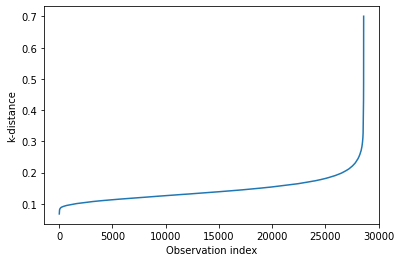

In [40]:
dist = dbscan_tuner(data_dbscan ,19)

In [41]:
# Too small eps values will mark some non-noise points as noise 
# and too large value will mark some noise points as cores
start = time.process_time()
dbscan = DBSCAN(eps = 0.1, min_samples = 20)
clusters = dbscan.fit_predict(train_data.loc[:, train_data.columns != 'y'])
end = time.process_time()
forestcover_dbscan_train_test_time = end - start
print(end - start)

85.140625


In [42]:
train_data['y_pred'] = clusters
train_data['prediction'] = train_data.apply(def_outlier, axis = 1)

In [43]:
original_columns = data.columns.to_list()
original_columns.remove('y')

data_w_score = pd.DataFrame(columns = train_data.columns.to_list())
data_w_score['score'] = pd.NaT
for i in set(clusters):
    if i == -1:
        continue
    score_data = train_data[train_data['y_pred'] == i].copy()
    center = score_data[original_columns].mean().to_list()
    score_data['score'] = score_data.apply(lambda x : distance.euclidean(x[original_columns].to_list(), center),1)
    data_w_score = data_w_score.append(score_data.copy(), ignore_index = True)

anomalies_data = train_data[train_data['y_pred'] == -1].copy()
anomalies_data['score'] = ''
cluster_centers = pd.pivot_table(train_data,
              index = 'y_pred',
              aggfunc = 'mean')

In [44]:
for i in range(len(anomalies_data)):
    anomalies_data['score'].iloc[i] = np.min(cluster_centers[cluster_centers.index != -1].apply(lambda x : 
                                                                                                distance.euclidean(x[original_columns].to_list(), anomalies_data[original_columns].iloc[i]),1))

data_for_auprc = pd.concat([data_w_score, anomalies_data])
data_for_auprc['y'] = data_for_auprc['y'].astype(int)

In [45]:
confusion_matrix(train_data['y'], train_data['prediction'])

array([[271724,  11577],
       [  1835,    912]], dtype=int64)

In [46]:
fpr, tpr, _ = metrics.roc_curve(data_for_auprc['y'], data_for_auprc['score'])
forestcover_dbscan_auc = metrics.auc(fpr, tpr)
metrics.auc(fpr, tpr)

0.6124261369434136

In [47]:
forestcover_dbscan_report = classification_report(train_data['y'], train_data['prediction'], target_names = ['0','1'], output_dict = True)
print(classification_report(train_data['y'], train_data['prediction'], target_names = ['0','1']))

              precision    recall  f1-score   support

           0       0.99      0.96      0.98    283301
           1       0.07      0.33      0.12      2747

    accuracy                           0.95    286048
   macro avg       0.53      0.65      0.55    286048
weighted avg       0.98      0.95      0.97    286048



In [48]:
precision, recall, thresholds = precision_recall_curve(data_for_auprc['y'], data_for_auprc['score'])
forestcover_dbscan_auc_precision_recall = metrics.auc(recall, precision)
print(forestcover_dbscan_auc_precision_recall)

0.024609927506381093


## Annthyroid

**Dataset source**: http://odds.cs.stonybrook.edu/annthyroid-dataset/ (data is transformed from .mat to .csv format)

Shebuti Rayana (2016). ODDS Library [http://odds.cs.stonybrook.edu]. Stony Brook, NY: Stony Brook University, Department of Computer Science.

**Aditional sources:**

Abe, Naoki, Bianca Zadrozny, and John Langford. “Outlier detection by active learning.” Proceedings of the 12th ACM SIGKDD international conference on Knowledge discovery and data mining. ACM, 2006.

Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou. “Isolation forest.” 2008 Eighth IEEE International Conference on Data Mining. IEEE, 2008.

K. M. Ting, J. T. S. Chuan, and F. T. Liu. “Mass: A New Ranking Measure for Anomaly Detection.“, IEEE Transactions on Knowledge and Data Engineering, 2009.

In [49]:
data = pd.read_csv('./annthyroid.csv')

In [50]:
data.head()

,Col1,Col2,Col3,Col4,Col5,Col6,y
0,0.73,0.00060,0.015,0.120,0.082,0.146,0
1,0.24,0.00025,0.030,0.143,0.133,0.108,0
2,0.47,0.00190,0.024,0.102,0.131,0.078,0
3,0.64,0.00090,0.017,0.077,0.090,0.085,0
4,0.23,0.00025,0.026,0.139,0.090,0.153,0


In [51]:
data.shape

(7200, 7)

In [52]:
pd.pivot_table(data,
             values = 'Col1',
               index = 'y', 
              aggfunc = 'count')

,Col1
y,
0,6666
1,534


### DBSCAN

In [53]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
train_data = min_max_scaler.fit_transform(data.copy())
train_data = pd.DataFrame(train_data)
train_data.columns = data.columns

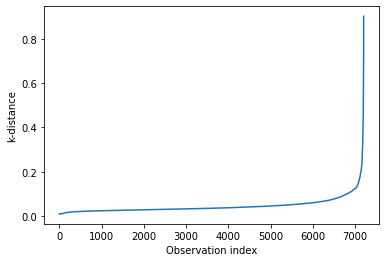

In [54]:
dist = dbscan_tuner(train_data ,11)

In [55]:
# Too small eps values will mark some non-noise points as noise 
# and too large value will mark some noise points as cores
start = time.process_time()
dbscan = DBSCAN(eps = 0.1, min_samples = 12)
clusters = dbscan.fit_predict(train_data.loc[:, train_data.columns != 'y'])
end = time.process_time()
annthyroid_dbscan_train_test_time = end - start
print(end - start)

0.734375


In [56]:
train_data['y_pred'] = clusters
train_data['prediction'] = train_data.apply(def_outlier, axis = 1)

In [57]:
original_columns = data.columns.to_list()
original_columns.remove('y')

data_w_score = pd.DataFrame(columns = train_data.columns.to_list())
data_w_score['score'] = pd.NaT
for i in set(clusters):
    if i == -1:
        continue
    score_data = train_data[train_data['y_pred'] == i].copy()
    center = score_data[original_columns].mean().to_list()
    score_data['score'] = score_data.apply(lambda x : distance.euclidean(x[original_columns].to_list(), center),1)
    data_w_score = data_w_score.append(score_data.copy(), ignore_index = True)

anomalies_data = train_data[train_data['y_pred'] == -1].copy()
anomalies_data['score'] = ''
cluster_centers = pd.pivot_table(train_data,
              index = 'y_pred',
              aggfunc = 'mean')

In [58]:
for i in range(len(anomalies_data)):
    anomalies_data['score'].iloc[i] = np.min(cluster_centers[cluster_centers.index != -1].apply(lambda x : 
                                                                                                distance.euclidean(x[original_columns].to_list(), anomalies_data[original_columns].iloc[i]),1))

data_for_auprc = pd.concat([data_w_score, anomalies_data])
data_for_auprc['y'] = data_for_auprc['y'].astype(int)

In [59]:
confusion_matrix(train_data['y'], train_data['prediction'])

array([[6539,  127],
       [ 469,   65]], dtype=int64)

In [60]:
fpr, tpr, _ = metrics.roc_curve(data_for_auprc['y'], data_for_auprc['score'])
annthyroid_dbscan_auc = metrics.auc(fpr, tpr)
metrics.auc(fpr, tpr)

0.5772259810250688

In [61]:
annthyroid_dbscan_report = classification_report(train_data['y'], train_data['prediction'], target_names = ['0','1'], output_dict = True)
print(classification_report(train_data['y'], train_data['prediction'], target_names = ['0','1']))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      6666
           1       0.34      0.12      0.18       534

    accuracy                           0.92      7200
   macro avg       0.64      0.55      0.57      7200
weighted avg       0.89      0.92      0.90      7200



In [62]:
precision, recall, thresholds = precision_recall_curve(data_for_auprc['y'], data_for_auprc['score'])
annthyroid_dbscan_auc_precision_recall = metrics.auc(recall, precision)
print(annthyroid_dbscan_auc_precision_recall)

0.11512900507154777


## Credit card

**Dataset source**: https://www.kaggle.com/mlg-ulb/creditcardfraud

**Additional sources:**

Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon

Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE

Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)

Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Aël; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier

Carcillo, Fabrizio; Le Borgne, Yann-Aël; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

Bertrand Lebichot, Yann-Aël Le Borgne, Liyun He, Frederic Oblé, Gianluca Bontempi Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection, INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019

Fabrizio Carcillo, Yann-Aël Le Borgne, Olivier Caelen, Frederic Oblé, Gianluca Bontempi Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection Information Sciences, 2019

Yann-Aël Le Borgne, Gianluca Bontempi Machine Learning for Credit Card Fraud Detection - Practical Handbook

In [63]:
data = pd.read_csv('./creditcard.csv')

In [64]:
data = data.drop(columns = ['Time'])

In [65]:
data.shape

(284807, 30)

In [66]:
data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [67]:
pd.pivot_table(data,
             values = 'V1',
               index = 'Class', 
              aggfunc = 'count')

,V1
Class,
0,284315
1,492


### DBSCAN

In [68]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
train_data = min_max_scaler.fit_transform(data.copy())
train_data = pd.DataFrame(train_data)
train_data.columns = data.columns

In [69]:
data_dbscan = train_data.sample(frac=0.1)

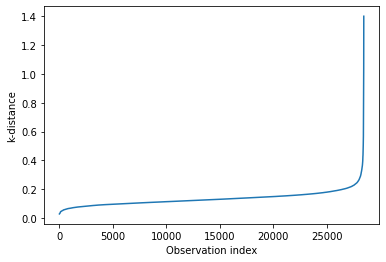

In [70]:
dist = dbscan_tuner(data_dbscan,57)

In [71]:
# Too small eps values will mark some non-noise points as noise 
# and too large value will mark some noise points as cores
start = time.process_time()
dbscan = DBSCAN(eps = 0.15, min_samples = 58)
clusters = dbscan.fit_predict(train_data.loc[:, train_data.columns != 'Class'])
end = time.process_time()
creditcard_dbscan_train_test_time = end - start
print(end - start)

2353.890625


In [72]:
train_data['y_pred'] = clusters
train_data['prediction'] = train_data.apply(def_outlier, axis = 1)

In [73]:
original_columns = data.columns.to_list()
original_columns.remove('Class')

data_w_score = pd.DataFrame(columns = train_data.columns.to_list())
data_w_score['score'] = pd.NaT
for i in set(clusters):
    if i == -1:
        continue
    score_data = train_data[train_data['y_pred'] == i].copy()
    center = score_data[original_columns].mean().to_list()
    score_data['score'] = score_data.apply(lambda x : distance.euclidean(x[original_columns].to_list(), center),1)
    data_w_score = data_w_score.append(score_data.copy(), ignore_index = True)

anomalies_data = train_data[train_data['y_pred'] == -1].copy()
anomalies_data['score'] = ''
cluster_centers = pd.pivot_table(train_data,
              index = 'y_pred',
              aggfunc = 'mean')

In [74]:
for i in range(len(anomalies_data)):
    anomalies_data['score'].iloc[i] = np.min(cluster_centers[cluster_centers.index != -1].apply(lambda x : 
                                                                                                distance.euclidean(x[original_columns].to_list(), anomalies_data[original_columns].iloc[i]),1))

data_for_auprc = pd.concat([data_w_score, anomalies_data])
data_for_auprc['Class'] = data_for_auprc['Class'].astype(int)

In [75]:
confusion_matrix(train_data['Class'], train_data['prediction'])

array([[277851,   6464],
       [    78,    414]], dtype=int64)

In [76]:
fpr, tpr, _ = metrics.roc_curve(data_for_auprc['Class'], data_for_auprc['score'])
creditcard_dbscan_auc = metrics.auc(fpr, tpr)
metrics.auc(fpr, tpr)

0.9488822514361647

In [77]:
creditcard_dbscan_report = classification_report(train_data['Class'], train_data['prediction'], target_names = ['0','1'], output_dict = True)
print(classification_report(train_data['Class'], train_data['prediction'], target_names = ['0','1']))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    284315
           1       0.06      0.84      0.11       492

    accuracy                           0.98    284807
   macro avg       0.53      0.91      0.55    284807
weighted avg       1.00      0.98      0.99    284807



In [78]:
precision, recall, thresholds = precision_recall_curve(data_for_auprc['Class'], data_for_auprc['score'])
creditcard_dbscan_auc_precision_recall = metrics.auc(recall, precision)
print(creditcard_dbscan_auc_precision_recall)

0.39041621363721374


## Mammography

**Dataset source**: http://odds.cs.stonybrook.edu/mammography-dataset/ (data is transformed from .mat to .csv format)

Shebuti Rayana (2016). ODDS Library [http://odds.cs.stonybrook.edu]. Stony Brook, NY: Stony Brook University, Department of Computer Science.

**Additional sources:**

Abe, Naoki, Bianca Zadrozny, and John Langford. “Outlier detection by active learning.” Proceedings of the 12th ACM SIGKDD international conference on Knowledge discovery and data mining. ACM, 2006.

Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou. “Isolation forest.” 2008 Eighth IEEE International Conference on Data Mining. IEEE, 2008.

K. M. Ting, J. T. S. Chuan, and F. T. Liu. “Mass: A New Ranking Measure for Anomaly Detection.“, IEEE Transactions on Knowledge and Data Engineering, 2009.

In [79]:
data = pd.read_csv('./mammography.csv')

In [80]:
data.head()

,Col1,Col2,Col3,Col4,Col5,Col6,y
0,0.230020,5.072578,-0.276061,0.832444,-0.377866,0.480322,0
1,0.155491,-0.169390,0.670652,-0.859553,-0.377866,-0.945723,0
2,-0.784415,-0.443654,5.674705,-0.859553,-0.377866,-0.945723,0
3,0.546088,0.131415,-0.456387,-0.859553,-0.377866,-0.945723,0
4,-0.102987,-0.394994,-0.140816,0.979703,-0.377866,1.013566,0


In [81]:
pd.pivot_table(data,
             values = 'Col1',
               index = 'y', 
              aggfunc = 'count')

,Col1
y,
0,10923
1,260


In [82]:
data.shape

(11183, 7)

### DBSCAN

In [83]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
train_data = min_max_scaler.fit_transform(data.copy())
train_data = pd.DataFrame(train_data)
train_data.columns = data.columns

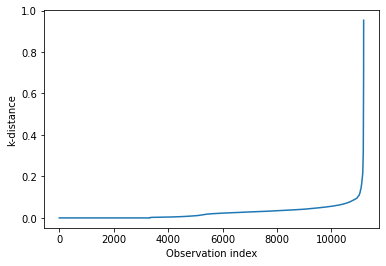

In [84]:
dist = dbscan_tuner(train_data,11)

In [85]:
# Too small eps values will mark some non-noise points as noise 
# and too large value will mark some noise points as cores
start = time.process_time()
dbscan = DBSCAN(eps = 0.07, min_samples = 12)
clusters = dbscan.fit_predict(train_data.loc[:, train_data.columns != 'y'])
end = time.process_time()
mammography_dbscan_train_test_time = end - start
print(end - start)

2.484375


In [86]:
train_data['y_pred'] = clusters
train_data['prediction'] = train_data.apply(def_outlier, axis = 1)

In [87]:
original_columns = data.columns.to_list()
original_columns.remove('y')

data_w_score = pd.DataFrame(columns = train_data.columns.to_list())
data_w_score['score'] = pd.NaT
for i in set(clusters):
    if i == -1:
        continue
    score_data = train_data[train_data['y_pred'] == i].copy()
    center = score_data[original_columns].mean().to_list()
    score_data['score'] = score_data.apply(lambda x : distance.euclidean(x[original_columns].to_list(), center),1)
    data_w_score = data_w_score.append(score_data.copy(), ignore_index = True)

anomalies_data = train_data[train_data['y_pred'] == -1].copy()
anomalies_data['score'] = ''
cluster_centers = pd.pivot_table(train_data,
              index = 'y_pred',
              aggfunc = 'mean')

In [88]:
for i in range(len(anomalies_data)):
    anomalies_data['score'].iloc[i] = np.min(cluster_centers[cluster_centers.index != -1].apply(lambda x : 
                                                                                                distance.euclidean(x[original_columns].to_list(), 
                                                                                                                   anomalies_data[original_columns].iloc[i]),1))

data_for_auprc = pd.concat([data_w_score, anomalies_data])
data_for_auprc['y'] = data_for_auprc['y'].astype(int)

In [89]:
confusion_matrix(train_data['y'], train_data['prediction'])

array([[10675,   248],
       [  198,    62]], dtype=int64)

In [90]:
fpr, tpr, _ = metrics.roc_curve(data_for_auprc['y'], data_for_auprc['score'])
mammography_dbscan_auc = metrics.auc(fpr, tpr)
metrics.auc(fpr, tpr)

0.8338910837400263

In [91]:
mammography_dbscan_report = classification_report(train_data['y'], train_data['prediction'], target_names = ['0','1'], output_dict = True)
print(classification_report(train_data['y'], train_data['prediction'], target_names = ['0','1']))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98     10923
           1       0.20      0.24      0.22       260

    accuracy                           0.96     11183
   macro avg       0.59      0.61      0.60     11183
weighted avg       0.96      0.96      0.96     11183



In [92]:
precision, recall, thresholds = precision_recall_curve(data_for_auprc['y'], data_for_auprc['score'])
mammography_dbscan_auc_precision_recall = metrics.auc(recall, precision)
print(mammography_dbscan_auc_precision_recall)

0.08346541583271654


## Shuttle

**Dataset source**: http://odds.cs.stonybrook.edu/shuttle-dataset/ (data is transformed from .mat to .csv format)

Shebuti Rayana (2016). ODDS Library [http://odds.cs.stonybrook.edu]. Stony Brook, NY: Stony Brook University, Department of Computer Science.

**Additional sources:**

Abe, Naoki, Bianca Zadrozny, and John Langford. “Outlier detection by active learning.” Proceedings of the 12th ACM SIGKDD international conference on Knowledge discovery and data mining. ACM, 2006.

Liu, Fei Tony, Kai Ming Ting, and Zhi-Hua Zhou. “Isolation forest.” 2008 Eighth IEEE International Conference on Data Mining. IEEE, 2008.

K. M. Ting, J. T. S. Chuan, and F. T. Liu. “Mass: A New Ranking Measure for Anomaly Detection.“, IEEE Transactions on Knowledge and Data Engineering, 2009.

Kai Ming Ting, Guang-Tong Zhou, Fei Tony Liu & Tan Swee Chuan. (2010). Mass Estimation and Its Applications. Proceedings of The 16th ACM SIGKDD Conference on Knowledge Discovery and Data Mining 2010. pp. 989-998.

Swee Chuan Tan, Kai Ming Ting & Fei Tony Liu. (2011). Fast Anomaly Detection for Streaming Data. Proceedings of the International Joint Conference on Artificial Intelligence 2011. pp.1151-1156.

In [93]:
data = pd.read_csv('./shuttle.csv', sep = ',')

In [94]:
data.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,y
0,50,21,77,0,28,0,27,48,22,1
1,53,0,82,0,52,-5,29,30,2,0
2,37,0,76,0,28,18,40,48,8,0
3,37,0,79,0,34,-26,43,46,2,0
4,85,0,88,-4,6,1,3,83,80,1


In [95]:
data.shape

(49097, 10)

In [96]:
pd.pivot_table(data,
             values = 'Col1',
               index = 'y', 
              aggfunc = 'count')

,Col1
y,
0,45586
1,3511


### DBSCAN

In [97]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
train_data = min_max_scaler.fit_transform(data.copy())
train_data = pd.DataFrame(train_data)
train_data.columns = data.columns

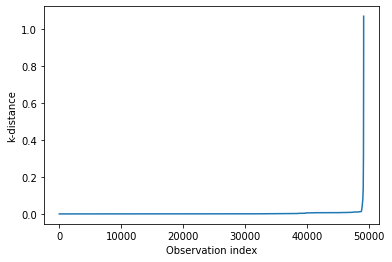

In [98]:
dist = dbscan_tuner(train_data, 17)

In [99]:
start = time.process_time()

dbscan = DBSCAN(eps = 0.005, min_samples = 18)
clusters = dbscan.fit_predict(train_data.loc[:, train_data.columns != 'y'])

end = time.process_time()
shuttle_dbscan_train_test_time = end - start
print(end - start)

5.71875


In [100]:
train_data['y_pred'] = clusters
train_data['prediction'] = train_data.apply(def_outlier, axis = 1)

In [101]:
original_columns = data.columns.to_list()
original_columns.remove('y')

data_w_score = pd.DataFrame(columns = train_data.columns.to_list())
data_w_score['score'] = pd.NaT
for i in set(clusters):
    if i == -1:
        continue
    score_data = train_data[train_data['y_pred'] == i].copy()
    center = score_data[original_columns].mean().to_list()
    score_data['score'] = score_data.apply(lambda x : distance.euclidean(x[original_columns].to_list(), center),1)
    data_w_score = data_w_score.append(score_data.copy(), ignore_index = True)

anomalies_data = train_data[train_data['y_pred'] == -1].copy()
anomalies_data['score'] = ''
cluster_centers = pd.pivot_table(train_data,
              index = 'y_pred',
              aggfunc = 'mean')

In [102]:
for i in range(len(anomalies_data)):
    anomalies_data['score'].iloc[i] = np.min(cluster_centers[cluster_centers.index != -1].apply(lambda x : 
                                                                            distance.euclidean(x[original_columns].to_list(), 
                                                                            anomalies_data[original_columns].iloc[i]),1))

data_for_auprc = pd.concat([data_w_score, anomalies_data])
data_for_auprc['y'] = data_for_auprc['y'].astype(int)

In [103]:
confusion_matrix(train_data['y'], train_data['prediction'])

array([[37675,  7911],
       [ 2217,  1294]], dtype=int64)

In [104]:
fpr, tpr, _ = metrics.roc_curve(data_for_auprc['y'], data_for_auprc['score'])
shuttle_dbscan_auc = metrics.auc(fpr, tpr)
metrics.auc(fpr, tpr)

0.6032828389264354

In [105]:
shuttle_dbscan_report = classification_report(train_data['y'], train_data['prediction'], target_names = ['0','1'], output_dict = True)
print(classification_report(train_data['y'], train_data['prediction'], target_names = ['0','1']))

              precision    recall  f1-score   support

           0       0.94      0.83      0.88     45586
           1       0.14      0.37      0.20      3511

    accuracy                           0.79     49097
   macro avg       0.54      0.60      0.54     49097
weighted avg       0.89      0.79      0.83     49097



In [106]:
precision, recall, thresholds = precision_recall_curve(data_for_auprc['y'], data_for_auprc['score'])
shuttle_dbscan_auc_precision_recall = metrics.auc(recall, precision)
print(shuttle_dbscan_auc_precision_recall)

0.1617144274869875


## mnist

**Dataset source**: http://odds.cs.stonybrook.edu/mnist-dataset/ (data is transformed from .mat to .csv format)

Shebuti Rayana (2016). ODDS Library [http://odds.cs.stonybrook.edu]. Stony Brook, NY: Stony Brook University, Department of Computer Science.

**Additional sources:**

Bandaragoda, Tharindu R., et al. “Efficient Anomaly Detection by Isolation Using Nearest Neighbour Ensemble.” 2014 IEEE International Conference on Data Mining Workshop. IEEE, 2014.

In [107]:
data = pd.read_csv('./mnist.csv')

In [108]:
data = data.drop(columns = ['Col1','Col4', 'Col7', 'Col22', 'Col27', 'Col29', 'Col38', 'Col41', 'Col51', 'Col53', 'Col54', 'Col61', 'Col62', 'Col71', 'Col73', 'Col79', 'Col87', 'Col88', 'Col89', 'Col90',
'Col92', 'Col100'])

In [109]:
pd.pivot_table(data,
             values = 'Col2',
               index = 'y', 
              aggfunc = 'count')

,Col2
y,
0,6903
1,700


In [110]:
data.shape

(7603, 79)

In [111]:
data.head()

,Col2,Col3,Col5,Col6,Col8,Col9,Col10,Col11,Col12,Col13,...,Col86,Col91,Col93,Col94,Col95,Col96,Col97,Col98,Col99,y
0,-73.804153,198.205963,-13.124617,-1.1501,-0.141633,179.249390,114.661163,-80.736702,130.659348,162.649841,...,-15.392716,188.055649,-4.469967,158.381409,-137.100632,27.131416,-2.274633,-0.00065,-12.351267,0
1,-73.804153,197.205963,-13.124617,-1.1501,-0.141633,179.249390,-44.338833,-80.736702,128.659348,190.649841,...,-15.392716,186.055649,-4.469967,123.381416,-137.100632,157.131409,-2.274633,-0.00065,-12.351267,0
2,-73.804153,-53.794033,-13.124617,-1.1501,-0.141633,-73.750618,-44.338833,170.263306,130.659348,46.649849,...,-15.392716,188.055649,-4.469967,157.381409,-137.100632,-93.868584,-2.274633,-0.00065,-12.351267,0
3,-73.804153,86.205963,-13.124617,-1.1501,-0.141633,76.249382,208.661163,107.263298,130.659348,190.649841,...,-15.392716,188.055649,-4.469967,157.381409,-137.100632,74.131416,-2.274633,-0.00065,-12.351267,0
4,-27.804153,199.205963,-13.124617,-1.1501,-0.141633,179.249390,-44.338833,-80.736702,130.659348,91.649849,...,-15.392716,188.055649,-4.469967,22.381416,-137.100632,159.131409,-2.274633,-0.00065,-12.351267,0


### DBSCAN

In [112]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
train_data = min_max_scaler.fit_transform(data.copy())
train_data = pd.DataFrame(train_data)
train_data.columns = data.columns

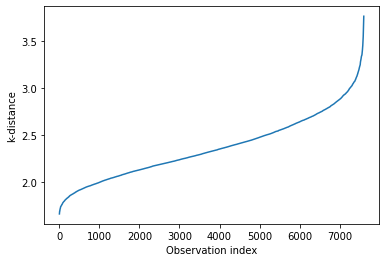

In [113]:
dist = dbscan_tuner(train_data,155)

In [114]:
start = time.process_time()

dbscan = DBSCAN(eps = 2.5, min_samples = 156)
clusters = dbscan.fit_predict(train_data.loc[:, train_data.columns != 'y'])

end = time.process_time()
mnist_dbscan_train_test_time = end - start
print(end - start)

3.734375


In [115]:
train_data['y_pred'] = clusters
train_data['prediction'] = train_data.apply(def_outlier, axis = 1)

In [116]:
original_columns = data.columns.to_list()
original_columns.remove('y')

data_w_score = pd.DataFrame(columns = train_data.columns.to_list())
data_w_score['score'] = pd.NaT
for i in set(clusters):
    if i == -1:
        continue
    score_data = train_data[train_data['y_pred'] == i].copy()
    center = score_data[original_columns].mean().to_list()
    score_data['score'] = score_data.apply(lambda x : distance.euclidean(x[original_columns].to_list(), center),1)
    data_w_score = data_w_score.append(score_data.copy(), ignore_index = True)

anomalies_data = train_data[train_data['y_pred'] == -1].copy()
anomalies_data['score'] = ''
cluster_centers = pd.pivot_table(train_data,
              index = 'y_pred',
              aggfunc = 'mean')

In [117]:
for i in range(len(anomalies_data)):
    anomalies_data['score'].iloc[i] = np.min(cluster_centers[cluster_centers.index != -1].apply(lambda x : 
                                                                                                distance.euclidean(x[original_columns].to_list(), 
                                                                                                                   anomalies_data[original_columns].iloc[i]),1))

data_for_auprc = pd.concat([data_w_score, anomalies_data])
data_for_auprc['y'] = data_for_auprc['y'].astype(int)

In [118]:
confusion_matrix(train_data['y'], train_data['prediction'])

array([[6782,  121],
       [ 559,  141]], dtype=int64)

In [119]:
fpr, tpr, _ = metrics.roc_curve(data_for_auprc['y'], data_for_auprc['score'])
mnist_dbscan_auc = metrics.auc(fpr, tpr)
metrics.auc(fpr, tpr)

0.8409796982678337

In [120]:
mnist_dbscan_report = classification_report(train_data['y'], train_data['prediction'], target_names = ['0','1'], output_dict = True)
print(classification_report(train_data['y'], train_data['prediction'], target_names = ['0','1']))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      6903
           1       0.54      0.20      0.29       700

    accuracy                           0.91      7603
   macro avg       0.73      0.59      0.62      7603
weighted avg       0.89      0.91      0.89      7603



In [121]:
precision, recall, thresholds = precision_recall_curve(data_for_auprc['y'], data_for_auprc['score'])
mnist_dbscan_auc_precision_recall = metrics.auc(recall, precision)
print(mnist_dbscan_auc_precision_recall)

0.3335835418896217


## vowels

**Dataset source**: http://odds.cs.stonybrook.edu/japanese-vowels-data/

Shebuti Rayana (2016). ODDS Library [http://odds.cs.stonybrook.edu]. Stony Brook, NY: Stony Brook University, Department of Computer Science.

**Additional sources:**

C. C. Aggarwal and S. Sathe, “Theoretical foundations and algorithms for outlier ensembles.” ACM SIGKDD Explorations Newsletter, vol. 17, no. 1, pp. 24–47, 2015.

Saket Sathe and Charu C. Aggarwal. LODES: Local Density meets Spectral Outlier Detection. SIAM Conference on Data Mining, 2016.

In [122]:
data = pd.read_csv('./vowels.csv')

In [123]:
pd.pivot_table(data,
             values = 'Col1',
               index = 'y', 
              aggfunc = 'count')

,Col1
y,
0.0,1406
1.0,50


In [124]:
data.shape

(1456, 13)

In [125]:
data.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,Col11,Col12,y
0,0.580469,-0.902534,0.617899,-0.997942,-2.463799,-0.846455,2.349849,0.375400,-0.649334,1.604637,-0.623060,-0.383125,0.0
1,0.784375,-1.077366,0.615781,-0.921911,-2.388553,-0.638047,2.106684,0.361018,-0.714317,1.260236,-0.423339,-0.287791,0.0
2,0.791292,-1.086242,0.669773,-0.806112,-2.260781,-0.538491,2.053282,0.266492,-0.842815,1.081797,-0.267201,-0.172203,0.0
3,1.217306,-1.083425,0.855483,-0.724879,-2.155552,-0.101879,1.768597,0.303151,-1.044710,0.655290,0.214298,-0.341840,0.0
4,1.065352,-1.030178,0.773297,-0.452289,-1.955907,0.248205,1.530474,0.253740,-0.968961,-0.208287,0.331578,0.007288,0.0


### DBSCAN

In [126]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
train_data = min_max_scaler.fit_transform(data.copy())
train_data = pd.DataFrame(train_data)
train_data.columns = data.columns

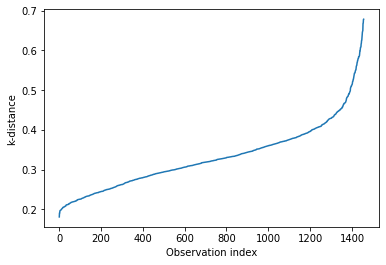

In [127]:
dist = dbscan_tuner(train_data,23)

In [128]:
start = time.process_time()

dbscan = DBSCAN(eps = 0.4, min_samples = 24)
clusters = dbscan.fit_predict(train_data.loc[:, train_data.columns != 'y'])

end = time.process_time()
vowels_dbscan_train_test_time = end - start
print(end - start)

0.09375


In [129]:
train_data['y_pred'] = clusters
train_data['prediction'] = train_data.apply(def_outlier, axis = 1)

In [130]:
original_columns = data.columns.to_list()
original_columns.remove('y')

data_w_score = pd.DataFrame(columns = train_data.columns.to_list())
data_w_score['score'] = pd.NaT
for i in set(clusters):
    if i == -1:
        continue
    score_data = train_data[train_data['y_pred'] == i].copy()
    center = score_data[original_columns].mean().to_list()
    score_data['score'] = score_data.apply(lambda x : distance.euclidean(x[original_columns].to_list(), center),1)
    data_w_score = data_w_score.append(score_data.copy(), ignore_index = True)

anomalies_data = train_data[train_data['y_pred'] == -1].copy()
anomalies_data['score'] = ''
cluster_centers = pd.pivot_table(train_data,
              index = 'y_pred',
              aggfunc = 'mean')

In [131]:
for i in range(len(anomalies_data)):
    anomalies_data['score'].iloc[i] = np.min(cluster_centers[cluster_centers.index != -1].apply(lambda x : 
                                                                                                distance.euclidean(x[original_columns].to_list(), 
                                                                                                anomalies_data[original_columns].iloc[i]),1))

data_for_auprc = pd.concat([data_w_score, anomalies_data])
data_for_auprc['y'] = data_for_auprc['y'].astype(int)

In [132]:
confusion_matrix(train_data['y'], train_data['prediction'])

array([[1375,   31],
       [  19,   31]], dtype=int64)

In [133]:
fpr, tpr, _ = metrics.roc_curve(data_for_auprc['y'], data_for_auprc['score'])
vowels_dbscan_auc = metrics.auc(fpr, tpr)
metrics.auc(fpr, tpr)

0.5521621621621622

In [134]:
vowels_dbscan_report = classification_report(train_data['y'], train_data['prediction'], target_names = ['0','1'], output_dict = True)
print(classification_report(train_data['y'], train_data['prediction'], target_names = ['0','1']))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1406
           1       0.50      0.62      0.55        50

    accuracy                           0.97      1456
   macro avg       0.74      0.80      0.77      1456
weighted avg       0.97      0.97      0.97      1456



In [135]:
precision, recall, thresholds = precision_recall_curve(data_for_auprc['y'], data_for_auprc['score'])
vowels_dbscan_auc_precision_recall = metrics.auc(recall, precision)
print(vowels_dbscan_auc_precision_recall)

0.04713195345469043


## Seismic

**Dataset source**: http://odds.cs.stonybrook.edu/seismic-dataset/ (data is transformed from .arff to .csv format)

Shebuti Rayana (2016). ODDS Library [http://odds.cs.stonybrook.edu]. Stony Brook, NY: Stony Brook University, Department of Computer Science.

**Additional sources:**

Saket Sathe and Charu C. Aggarwal. LODES: Local Density meets Spectral Outlier Detection. SIAM Conference on Data Mining, 2016.

In [136]:
data = pd.read_csv('./seismic.csv', sep = ',')

In [137]:
data = data.drop(columns = ['nbumps6','nbumps7','nbumps89'])

In [138]:
data.shape

(2584, 16)

In [139]:
drop_enc = OneHotEncoder(drop='first').fit_transform(data[['seismic','seismoacoustic','shift','ghazard']])

In [140]:
cat_var = pd.DataFrame(drop_enc.toarray())
cat_var.columns = ['seismic: b', 'seismoacoustic: b','seismoacoustic: c','shift: W','ghazard: b','ghazard: c']

In [141]:
data = pd.concat([data, cat_var], axis = 1)

In [142]:
data = data.drop(columns = ['seismic','seismoacoustic','shift','ghazard'])

In [143]:
data.head()

,genergy,gpuls,gdenergy,gdpuls,nbumps,nbumps2,nbumps3,nbumps4,nbumps5,energy,maxenergy,class,seismic: b,seismoacoustic: b,seismoacoustic: c,shift: W,ghazard: b,ghazard: c
0,15180,48,-72,-72,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,14720,33,-70,-79,1,0,1,0,0,2000,2000,0,0.0,0.0,0.0,0.0,0.0,0.0
2,8050,30,-81,-78,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,28820,171,-23,40,1,0,1,0,0,3000,3000,0,0.0,0.0,0.0,0.0,0.0,0.0
4,12640,57,-63,-52,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [144]:
pd.pivot_table(data,
             values = 'genergy',
               index = 'class', 
              aggfunc = 'count')

,genergy
class,
0,2414
1,170


### DBSCAN

In [145]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
train_data = min_max_scaler.fit_transform(data.copy())
train_data = pd.DataFrame(train_data)
train_data.columns = data.columns

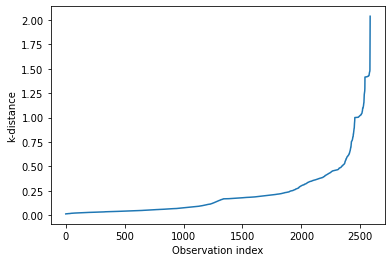

In [146]:
dist = dbscan_tuner(train_data,41)

In [147]:
start = time.process_time()
dbscan = DBSCAN(eps = 0.25, min_samples = 42)
clusters = dbscan.fit_predict(train_data.loc[:, train_data.columns != 'class'])
end = time.process_time()
seismic_dbscan_train_test_time = end - start
print(end - start)

0.515625


In [148]:
train_data['y_pred'] = clusters
train_data['prediction'] = train_data.apply(def_outlier, axis = 1)

In [149]:
original_columns = data.columns.to_list()
original_columns.remove('class')

data_w_score = pd.DataFrame(columns = train_data.columns.to_list())
data_w_score['score'] = pd.NaT
for i in set(clusters):
    if i == -1:
        continue
    score_data = train_data[train_data['y_pred'] == i].copy()
    center = score_data[original_columns].mean().to_list()
    score_data['score'] = score_data.apply(lambda x : distance.euclidean(x[original_columns].to_list(), center),1)
    data_w_score = data_w_score.append(score_data.copy(), ignore_index = True)

anomalies_data = train_data[train_data['y_pred'] == -1].copy()
anomalies_data['score'] = ''
cluster_centers = pd.pivot_table(train_data,
              index = 'y_pred',
              aggfunc = 'mean')

In [150]:
for i in range(len(anomalies_data)):
    anomalies_data['score'].iloc[i] = np.min(cluster_centers[cluster_centers.index != -1].apply(lambda x : 
                                                                                                distance.euclidean(x[original_columns].to_list(), 
                                                                                                                   anomalies_data[original_columns].iloc[i]),1))

data_for_auprc = pd.concat([data_w_score, anomalies_data])
data_for_auprc['class'] = data_for_auprc['class'].astype(int)

In [151]:
confusion_matrix(train_data['class'], train_data['prediction'])

array([[2008,  406],
       [ 108,   62]], dtype=int64)

In [152]:
fpr, tpr, _ = metrics.roc_curve(data_for_auprc['class'], data_for_auprc['score'])
seismic_dbscan_auc = metrics.auc(fpr, tpr)
metrics.auc(fpr, tpr)

0.7147156294166382

In [153]:
seismic_dbscan_report = classification_report(train_data['class'], train_data['prediction'], target_names = ['0','1'], output_dict=True)
print(classification_report(train_data['class'], train_data['prediction'], target_names = ['0','1']))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89      2414
           1       0.13      0.36      0.19       170

    accuracy                           0.80      2584
   macro avg       0.54      0.60      0.54      2584
weighted avg       0.90      0.80      0.84      2584



In [154]:
precision, recall, thresholds = precision_recall_curve(data_for_auprc['class'], data_for_auprc['score'])
seismic_dbscan_auc_precision_recall = metrics.auc(recall, precision)
print(seismic_dbscan_auc_precision_recall)

0.11742727107228718


## Musk

**Dataset source**: http://odds.cs.stonybrook.edu/musk-dataset/ (data is transformed from .mat to .csv format)

Shebuti Rayana (2016). ODDS Library [http://odds.cs.stonybrook.edu]. Stony Brook, NY: Stony Brook University, Department of Computer Science.

**Additional sources:**

C. C. Aggarwal and S. Sathe, “Theoretical foundations and algorithms for outlier ensembles.” ACM SIGKDD Explorations Newsletter, vol. 17, no. 1, pp. 24–47, 2015.

In [155]:
data = pd.read_csv('./musk.csv', sep = ',')

In [156]:
data.head()

,Col1,Col2,Col3,Col4,Col5,Col6,Col7,Col8,Col9,Col10,...,Col158,Col159,Col160,Col161,Col162,Col163,Col164,Col165,Col166,y
0,46.0,-108.0,-60.0,-69.0,-117.0,49.0,38.0,-161.0,-8.0,5.0,...,-308.0,52.0,-7.0,39.0,126.0,156.0,-50.0,-112.0,96.0,1.0
1,41.0,-188.0,-145.0,22.0,-117.0,-6.0,57.0,-171.0,-39.0,-100.0,...,-59.0,-2.0,52.0,103.0,136.0,169.0,-61.0,-136.0,79.0,1.0
2,46.0,-194.0,-145.0,28.0,-117.0,73.0,57.0,-168.0,-39.0,-22.0,...,-134.0,-154.0,57.0,143.0,142.0,165.0,-67.0,-145.0,39.0,1.0
3,41.0,-188.0,-145.0,22.0,-117.0,-7.0,57.0,-170.0,-39.0,-99.0,...,-60.0,-4.0,52.0,104.0,136.0,168.0,-60.0,-135.0,80.0,1.0
4,41.0,-188.0,-145.0,22.0,-117.0,-7.0,57.0,-170.0,-39.0,-99.0,...,-60.0,-4.0,52.0,104.0,137.0,168.0,-60.0,-135.0,80.0,1.0


In [157]:
data['y'] = data['y'].astype(int)

In [158]:
data.shape

(3062, 167)

In [159]:
pd.pivot_table(data,
             values = 'Col1',
               index = 'y', 
              aggfunc = 'count')

,Col1
y,
0,2965
1,97


### DBSCAN

In [160]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
train_data = min_max_scaler.fit_transform(data.copy())
train_data = pd.DataFrame(train_data)
train_data.columns = data.columns

In [161]:
#dist = dbscan_tuner(train_data,331)

In [162]:
start = time.process_time()
dbscan = DBSCAN(eps = 3.2, min_samples = 332)
clusters = dbscan.fit_predict(train_data.loc[:, train_data.columns != 'y'])
end = time.process_time()
musk_dbscan_train_test_time = end - start
print(end - start)

1.78125


In [163]:
train_data['y_pred'] = clusters
train_data['prediction'] = train_data.apply(def_outlier, axis = 1)

In [164]:
original_columns = data.columns.to_list()
original_columns.remove('y')

data_w_score = pd.DataFrame(columns = train_data.columns.to_list())
data_w_score['score'] = pd.NaT
for i in set(clusters):
    if i == -1:
        continue
    score_data = train_data[train_data['y_pred'] == i].copy()
    center = score_data[original_columns].mean().to_list()
    score_data['score'] = score_data.apply(lambda x : distance.euclidean(x[original_columns].to_list(), center),1)
    data_w_score = data_w_score.append(score_data.copy(), ignore_index = True)

anomalies_data = train_data[train_data['y_pred'] == -1].copy()
anomalies_data['score'] = ''
cluster_centers = pd.pivot_table(train_data,
              index = 'y_pred',
              aggfunc = 'mean')

In [165]:
for i in range(len(anomalies_data)):
    anomalies_data['score'].iloc[i] = np.min(cluster_centers[cluster_centers.index != -1].apply(lambda x : 
                                                                                                distance.euclidean(x[original_columns].to_list(), 
                                                                                                                   anomalies_data[original_columns].iloc[i]),1))

data_for_auprc = pd.concat([data_w_score, anomalies_data])
data_for_auprc['y'] = data_for_auprc['y'].astype(int)

In [166]:
confusion_matrix(train_data['y'], train_data['prediction'])

array([[2965,    0],
       [   8,   89]], dtype=int64)

In [167]:
fpr, tpr, _ = metrics.roc_curve(data_for_auprc['y'], data_for_auprc['score'])
musk_dbscan_auc = metrics.auc(fpr, tpr)
metrics.auc(fpr, tpr)

1.0

In [168]:
musk_dbscan_report = classification_report(train_data['y'], train_data['prediction'], target_names = ['0','1'], output_dict=True)
print(classification_report(train_data['y'], train_data['prediction'], target_names = ['0','1']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2965
           1       1.00      0.92      0.96        97

    accuracy                           1.00      3062
   macro avg       1.00      0.96      0.98      3062
weighted avg       1.00      1.00      1.00      3062



In [169]:
precision, recall, thresholds = precision_recall_curve(data_for_auprc['y'], data_for_auprc['score'])
musk_dbscan_auc_precision_recall = metrics.auc(recall, precision)
print(musk_dbscan_auc_precision_recall)

0.9999999999999998


## bank

**Dataset source**: https://github.com/GuansongPang/ADRepository-Anomaly-detection-datasets/tree/main/categorical%20data

Pang, G., Shen, C., Cao, L., & Hengel, A. V. D. (2021). Deep learning for anomaly detection: A review. ACM Computing Surveys (CSUR), 54(2), 1-38.

In [170]:
data = pd.read_csv('./bank.csv')

In [171]:
data.head()

,age,job=housemaid,job=services,job=admin.,job=blue-collar,job=technician,job=retired,job=management,job=unemployed,job=self-employed,...,previous,poutcome=nonexistent,poutcome=failure,poutcome=success,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,class
0,0.209877,0,0,0,0,0,0,0,0,0,...,0.000000,1,0,0,1.000000,0.882307,0.376569,0.980730,1.000000,0
1,0.296296,0,0,1,0,0,0,0,0,0,...,0.000000,1,0,0,1.000000,0.484412,0.615063,0.981183,1.000000,0
2,0.246914,1,0,0,0,0,0,0,0,0,...,0.000000,1,0,0,0.937500,0.698753,0.602510,0.957379,0.859735,0
3,0.160494,0,1,0,0,0,0,0,0,0,...,0.142857,0,1,0,0.333333,0.269680,0.192469,0.150759,0.512287,0
4,0.530864,0,0,0,1,0,0,0,0,0,...,0.000000,1,0,0,0.333333,0.340608,0.154812,0.174790,0.512287,1


In [172]:
pd.pivot_table(data,
             values = 'age',
               index = 'class', 
              aggfunc = 'count')

,age
class,
0,36548
1,4640


### DBSCAN

In [173]:
min_max_scaler = MinMaxScaler(feature_range=(0, 1))
train_data = min_max_scaler.fit_transform(data.copy())
train_data = pd.DataFrame(train_data)
train_data.columns = data.columns

In [174]:
#dist = dbscan_tuner(train_data,123)

In [175]:
start = time.process_time()
dbscan = DBSCAN(eps = 2, min_samples = 124)
clusters = dbscan.fit_predict(train_data.loc[:, train_data.columns != 'class'])
end = time.process_time()
bank_dbscan_train_test_time = end - start
print(end - start)

28.1875


In [176]:
train_data['y_pred'] = clusters
train_data['prediction'] = train_data.apply(def_outlier, axis = 1)

In [177]:
original_columns = data.columns.to_list()
original_columns.remove('class')

data_w_score = pd.DataFrame(columns = train_data.columns.to_list())
data_w_score['score'] = pd.NaT
for i in set(clusters):
    if i == -1:
        continue
    score_data = train_data[train_data['y_pred'] == i].copy()
    center = score_data[original_columns].mean().to_list()
    score_data['score'] = score_data.apply(lambda x : distance.euclidean(x[original_columns].to_list(), center),1)
    data_w_score = data_w_score.append(score_data.copy(), ignore_index = True)

anomalies_data = train_data[train_data['y_pred'] == -1].copy()
anomalies_data['score'] = ''
cluster_centers = pd.pivot_table(train_data,
              index = 'y_pred',
              aggfunc = 'mean')

In [178]:
for i in range(len(anomalies_data)):
    anomalies_data['score'].iloc[i] = np.min(cluster_centers[cluster_centers.index != -1].apply(lambda x : 
                                                                                                distance.euclidean(x[original_columns].to_list(), 
                                                                                                                   anomalies_data[original_columns].iloc[i]),1))

data_for_auprc = pd.concat([data_w_score, anomalies_data])
data_for_auprc['class'] = data_for_auprc['class'].astype(int)

In [179]:
confusion_matrix(train_data['class'], train_data['prediction'])

array([[27347,  9201],
       [ 2489,  2151]], dtype=int64)

In [180]:
fpr, tpr, _ = metrics.roc_curve(data_for_auprc['class'], data_for_auprc['score'])
bank_dbscan_auc = metrics.auc(fpr, tpr)
metrics.auc(fpr, tpr)

0.6790017284779959

In [181]:
bank_dbscan_report = classification_report(train_data['class'], train_data['prediction'], target_names = ['0','1'], output_dict=True)
print(classification_report(train_data['class'], train_data['prediction'], target_names = ['0','1']))

              precision    recall  f1-score   support

           0       0.92      0.75      0.82     36548
           1       0.19      0.46      0.27      4640

    accuracy                           0.72     41188
   macro avg       0.55      0.61      0.55     41188
weighted avg       0.83      0.72      0.76     41188



In [182]:
precision, recall, thresholds = precision_recall_curve(data_for_auprc['class'], data_for_auprc['score'])
bank_dbscan_auc_precision_recall = metrics.auc(recall, precision)
print(bank_dbscan_auc_precision_recall)

0.26888140751138884


## Performance

In [183]:
performance = pd.DataFrame(columns = ['F1 score', 'recall', 'precision', 'AUC', 'AUPRC', 'Total time'])

In [184]:
f1_score_dbscan = {'arrhythmia':arrhythmia_dbscan_report['1']['f1-score'],
                       'cardio':cardio_dbscan_report['1']['f1-score'], 
                        'forestcover':forestcover_dbscan_report['1']['f1-score'], 
                       'annthyroid':annthyroid_dbscan_report['1']['f1-score'],       
                        'creditcard':creditcard_dbscan_report['1']['f1-score'], 
                       'mammography':mammography_dbscan_report['1']['f1-score'], 
                        'shuttle':shuttle_dbscan_report['1']['f1-score'], 
                      'mnist':mnist_dbscan_report['1']['f1-score'], 
                  'vowels':vowels_dbscan_report['1']['f1-score'], 
                  'seismic':seismic_dbscan_report['1']['f1-score'], 
                  'musk':musk_dbscan_report['1']['f1-score'], 
                  'bank':bank_dbscan_report['1']['f1-score']}
f1_score_dbscan_df = pd.DataFrame.from_dict(f1_score_dbscan, orient='index', columns = ['F1 score']).reset_index()

In [185]:
recall_dbscan = {'arrhythmia':arrhythmia_dbscan_report['1']['recall'],
                       'cardio':cardio_dbscan_report['1']['recall'], 
                        'forestcover':forestcover_dbscan_report['1']['recall'], 
                       'annthyroid':annthyroid_dbscan_report['1']['recall'],       
                        'creditcard':creditcard_dbscan_report['1']['recall'], 
                       'mammography':mammography_dbscan_report['1']['recall'], 
                        'shuttle':shuttle_dbscan_report['1']['recall'], 
                      'mnist':mnist_dbscan_report['1']['recall'], 
                  'vowels':vowels_dbscan_report['1']['recall'], 
                  'seismic':seismic_dbscan_report['1']['recall'], 
                  'musk':musk_dbscan_report['1']['recall'], 
                  'bank':bank_dbscan_report['1']['recall'], }
recall_dbscan_df = pd.DataFrame.from_dict(recall_dbscan, orient='index', columns = ['Recall']).reset_index()

In [186]:
precision_dbscan = {'arrhythmia':arrhythmia_dbscan_report['1']['precision'],
                       'cardio':cardio_dbscan_report['1']['precision'], 
                        'forestcover':forestcover_dbscan_report['1']['precision'], 
                       'annthyroid':annthyroid_dbscan_report['1']['precision'],       
                        'creditcard':creditcard_dbscan_report['1']['precision'], 
                       'mammography':mammography_dbscan_report['1']['precision'], 
                        'shuttle':shuttle_dbscan_report['1']['precision'], 
                      'mnist':mnist_dbscan_report['1']['precision'], 
                  'vowels':vowels_dbscan_report['1']['precision'], 
                  'seismic':seismic_dbscan_report['1']['precision'], 
                  'musk':musk_dbscan_report['1']['precision'], 
                  'bank':bank_dbscan_report['1']['precision'], }
precision_dbscan_df = pd.DataFrame.from_dict(precision_dbscan, orient='index', columns = ['Precision']).reset_index()

In [187]:
auc_dbscan = {'arrhythmia':arrhythmia_dbscan_auc,
                       'cardio':cardio_dbscan_auc, 
                        'forestcover':forestcover_dbscan_auc, 
                       'annthyroid':annthyroid_dbscan_auc,       
                        'creditcard':creditcard_dbscan_auc, 
                       'mammography':mammography_dbscan_auc, 
                        'shuttle':shuttle_dbscan_auc, 
                      'mnist':mnist_dbscan_auc, 
                  'vowels':vowels_dbscan_auc, 
                  'seismic':seismic_dbscan_auc, 
                  'musk':musk_dbscan_auc, 
                  'bank':bank_dbscan_auc}
auc_dbscan_df = pd.DataFrame.from_dict(auc_dbscan, orient='index', columns = ['AUC']).reset_index()

In [188]:
auprc_dbscan = {'arrhythmia':arrhythmia_dbscan_auc_precision_recall,
                       'cardio':cardio_dbscan_auc_precision_recall, 
                        'forestcover':forestcover_dbscan_auc_precision_recall, 
                       'annthyroid':annthyroid_dbscan_auc_precision_recall,       
                        'creditcard':creditcard_dbscan_auc_precision_recall, 
                       'mammography':mammography_dbscan_auc_precision_recall, 
                        'shuttle':shuttle_dbscan_auc_precision_recall, 
                      'mnist':mnist_dbscan_auc_precision_recall, 
                  'vowels':vowels_dbscan_auc_precision_recall, 
                  'seismic':seismic_dbscan_auc_precision_recall, 
                  'musk':musk_dbscan_auc_precision_recall, 
                  'bank':bank_dbscan_auc_precision_recall}
auprc_dbscan_df = pd.DataFrame.from_dict(auprc_dbscan, orient='index', columns = ['AUPRC']).reset_index()

In [189]:
total_time_dbscan = {'arrhythmia':arrhythmia_dbscan_train_test_time,
                       'cardio':cardio_dbscan_train_test_time, 
                        'forestcover':forestcover_dbscan_train_test_time, 
                       'annthyroid':annthyroid_dbscan_train_test_time,       
                        'creditcard':creditcard_dbscan_train_test_time, 
                       'mammography':mammography_dbscan_train_test_time, 
                        'shuttle':shuttle_dbscan_train_test_time, 
                      'mnist':mnist_dbscan_train_test_time, 
                  'vowels':vowels_dbscan_train_test_time, 
                  'seismic':seismic_dbscan_train_test_time, 
                  'musk':musk_dbscan_train_test_time, 
                  'bank':bank_dbscan_train_test_time}
total_time_dbscan_df = pd.DataFrame.from_dict(total_time_dbscan, orient='index', columns = ['Total time']).reset_index()

In [190]:
pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(f1_score_dbscan_df, recall_dbscan_df, how = 'inner'), 
                                    precision_dbscan_df, how ='inner'),
         auc_dbscan_df, how = 'inner'), auprc_dbscan_df, how = 'inner'), total_time_dbscan_df, how = 'inner')

,index,F1 score,Recall,Precision,AUC,AUPRC,Total time
0,arrhythmia,0.411765,0.318182,0.583333,0.797535,0.456049,0.812500
1,cardio,0.352941,0.238636,0.677419,0.945578,0.641929,0.453125
2,forestcover,0.119716,0.331999,0.073024,0.612426,0.024610,85.140625
3,annthyroid,0.179063,0.121723,0.338542,0.577226,0.115129,0.734375
4,creditcard,0.112347,0.841463,0.060192,0.948882,0.390416,2353.890625
5,mammography,0.217544,0.238462,0.200000,0.833891,0.083465,2.484375
6,shuttle,0.203523,0.368556,0.140576,0.603283,0.161714,5.718750
7,mnist,0.293139,0.201429,0.538168,0.840980,0.333584,3.734375
8,vowels,0.553571,0.620000,0.500000,0.552162,0.047132,0.093750
9,seismic,0.194357,0.364706,0.132479,0.714716,0.117427,0.515625
